In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics, preprocessing
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    VotingRegressor,
)
from sklearn.linear_model import QuantileRegressor
from sklearn.metrics import make_scorer, d2_pinball_score
from sklearn.model_selection import (
    RandomizedSearchCV,
    TimeSeriesSplit,
    cross_val_predict,
    cross_val_score,
)
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
scaler = StandardScaler()

In [3]:
def get_X(scaler, histfile="ВС_DS_Сбер.csv", start="01-01-2010"):

    df = pd.read_csv(
        histfile,
        delimiter=";",
        parse_dates={"date": ["REPORTDATE"]},
        infer_datetime_format=True,
    )
    lags = [
        30,
        60,
        90,
        120,
        150,
        180,
        210,
        240,
        270,
        300,
        330,
        360,
    ]  # lags for every possible input horizon
    df = df.rename(columns={"VALUE": "value"})
    df["time"] = np.arange(len(df.index))
    df["dayofmonth"] = df.date.dt.day
    df["dayofyear"] = df.date.dt.day_of_year
    df["min30"] = df.value.rolling(30).min()
    df["min360"] = df.value.rolling(360).min()
    
    for lag in lags:
        df[f"lag_{lag}"] = np.where(df.value.values >= 0, df.value.shift(lag), np.nan)
    
    df = df.loc[df.date >= start]
    df = df.dropna().reset_index()
    
    min30dayindex = (
        (df.value.rolling(30).apply(np.argmin) + df.index - 30 + 1)
        .fillna(0)
        .astype("Int64")
    )
    min360dayindex = (
        (df.value.rolling(360).apply(np.argmin) + df.index - 360 + 1)
        .fillna(0)
        .astype("Int64")
    )
    df["min30day"] = [
        df.dayofmonth[x] for x in min30dayindex
    ]  # day of month with minimum for last 30
    df["min360day"] = [
        df.dayofyear[x] for x in min360dayindex
    ]  # day of year with minimum for last 360
    for lag in lags:
        df[f"change_{lag}"] = 100 * (df["value"] - df[f"lag_{lag}"]) / df[f"lag_{lag}"]
        df[f"change_pow_{lag}"] = df[f"change_{lag}"] ** 2
        df[f"sma_change_{lag}"] = df[f"change_{lag}"].rolling(lag).mean()
    df = df.drop(columns={"index"})
    df = df.fillna(0)

    # Form X and y vectors from df with features we need
    X = pd.DataFrame(index=df.index)

    for lag in lags:
        X[f"change_{lag}"] = df[f"change_{lag}"]
        X[f"value"] = df[f"value"]
        X[f"change_pow_{lag}"] = df[f"change_pow_{lag}"]
        X[f"lag_{lag}"] = df[f"lag_{lag}"]
        X[f"sma_change_{lag}"] = df[f"sma_change_{lag}"]
        X["dayofmonth"] = df["dayofmonth"]
        X["dayofyear"] = df["dayofyear"]

    colnames = list(X.columns)
    X = pd.DataFrame(scaler.fit_transform(X), columns=colnames)
    return X.copy(), df

In [4]:
X, df = get_X(scaler)
colnames = list(X.columns)
X.shape

(1751, 51)

In [5]:
X.isnull().values.any()

False

In [6]:
lags = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
for lag in lags:
    df[f"target_{lag}"] = np.where(df.value.values >= 0, df.value.shift(-lag), np.nan)

y = pd.DataFrame(index=df.index)
for lag in lags:
    y[f"target_change_{lag}"] = np.where(
        df.value.values >= 0,
        100 * (df[f"target_{lag}"] - df["value"]) / df["value"],
        np.nan,
    )
y.shape

(1751, 12)

In [7]:
y.isnull().values.any()

True

In [8]:
test_size = 500
X_train, X_test, y_train, y_test = (
    X[:-test_size],
    X[-test_size:],
    y[:-test_size],
    y[-test_size:],
)

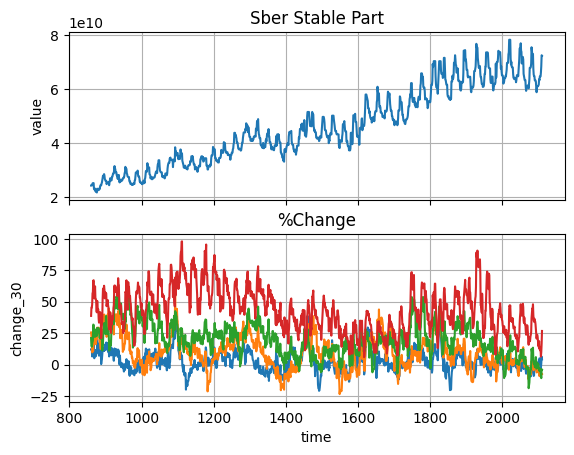

In [9]:
# Look at our data a bit

sta = 500
sto = 5000
fig, ax = plt.subplots(2, 1, sharex=True)
sns.lineplot(x="time", y="value", data=df[sta:sto], ax=ax[0])
sns.lineplot(x="time", y="change_30", data=df[sta:sto], ax=ax[1])
sns.lineplot(x="time", y="change_90", data=df[sta:sto], ax=ax[1])
sns.lineplot(x="time", y="change_180", data=df[sta:sto], ax=ax[1])
sns.lineplot(x="time", y="change_360", data=df[sta:sto], ax=ax[1])
ax[0].set_title("Sber Stable Part")
ax[1].set_title("%Change")
ax[0].grid()
ax[1].grid()

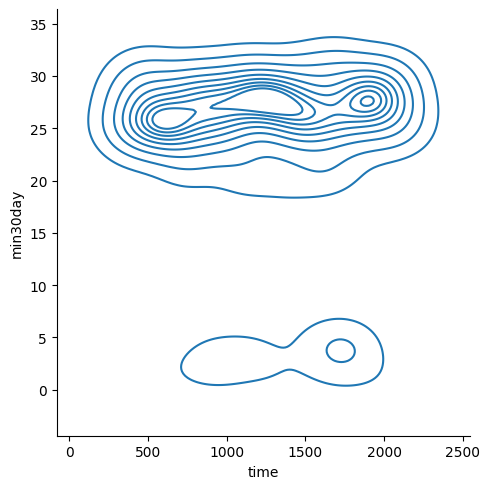

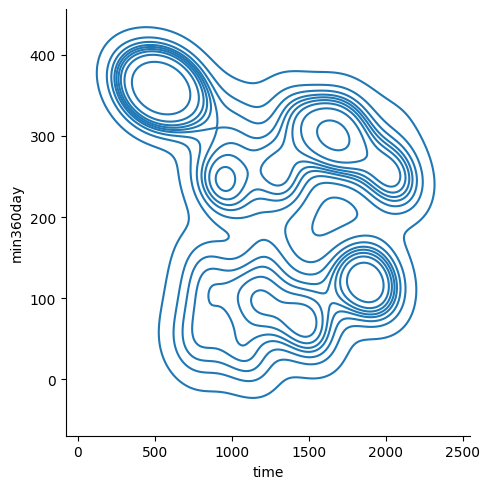

In [10]:
sns.displot(x=df.time, y=df.min30day, kind="kde")
sns.displot(x=df.time, y=df.min360day, kind="kde")

# We see that day of month is important seasonality
# Day of year is not so strong but still valuable, so we use both in X vector

In [11]:
pinball5 = make_scorer(d2_pinball_score, alpha=0.05)

In [12]:
# commented to save your time launching notebook, model dumped
'''
reg1 = GradientBoostingRegressor(loss="absolute_error", n_estimators=700, learning_rate=0.5, max_depth=3, min_samples_leaf=12, random_state=1)
reg3 = QuantileRegressor(alpha=0.01, quantile=0.05, solver='highs-ds')

estimators=[('gb', reg1), ('qr', reg3)]

model = MultiOutputRegressor(VotingRegressor(estimators, weights=[1, 2]), n_jobs=-1)
'''

In [13]:
# commented to save your time launching notebook, model dumped
'''
tscv = TimeSeriesSplit(n_splits=2, test_size=test_size)

params = {
    "estimator__gb__loss": ["absolute_error"],
    "estimator__gb__n_estimators": range(1, 500, 10),
    "estimator__gb__max_depth": range(1, 7),
    "estimator__gb__min_samples_leaf": range(1, 30),
    "estimator__gb__learning_rate": [0.01, 0.3, 1, 3],
    "estimator__qr__alpha": [0.01, 0.1, 1],
    "estimator__qr__quantile": [0.1]
    #"estimator__rf__criterion": ["squared_error", "absolute_error"],
    #"estimator__rf__max_features": [0.3, 1, 3],
    #"estimator__rf__n_estimators": range(100, 1000, 100),
    #"estimator__rf__max_depth": range(2, 10),
    #"kernel": ["rbf", "poly", "rbf", "sigmoid", "precomputed"],
    #"degree": [1, 2, 3], 
    #"gamma": ["scale", "auto"], 
    #"coef0": [0.0, 0.01, 0.1, 0.5, 1., 5.], 
    #"tol": [0.001, 0.01, 0.1],
    #"C": [0.01, 0.1, 1.],
    #"epsilon": [0.01, 0.1, 1],
    #"shrinking": [True, False],
}
search = RandomizedSearchCV(
    estimator=model,
    cv=tscv,
    param_distributions=params,
    random_state=1,
    n_jobs=-1,
    scoring=pinball5,
)
search.fit(X_train, y_train)
'''

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=500),
                   estimator=MultiOutputRegressor(estimator=VotingRegressor(estimators=[('gb',
                                                                                         GradientBoostingRegressor(learning_rate=0.5,
                                                                                                                   loss='absolute_error',
                                                                                                                   min_samples_leaf=12,
                                                                                                                   n_estimators=700,
                                                                                                                   random_state=1)),
                                                                                        ('qr',
                                                                                         QuantileRegressor(alpha=0.01,
                                                                                                           quantile=0.05,
                                                                                                           solver='highs-ds...
                   param_distributions={'estimator__gb__learning_rate': [0.01,
                                                                         0.3, 1,
                                                                         3],
                                        'estimator__gb__loss': ['absolute_error'],
                                        'estimator__gb__max_depth': range(1, 7),
                                        'estimator__gb__min_samples_leaf': range(1, 30),
                                        'estimator__gb__n_estimators': range(1, 500, 10),
                                        'estimator__qr__alpha': [0.01, 0.1, 1],
                                        'estimator__qr__quantile': [0.1]},
                   random_state=1,
                   scoring=make_scorer(d2_pinball_score, alpha=0.05))

In [14]:
'''best = search.best_estimator_

best.fit(X_train, y_train)'''

MultiOutputRegressor(estimator=VotingRegressor(estimators=[('gb',
                                                            GradientBoostingRegressor(learning_rate=0.3,
                                                                                      loss='absolute_error',
                                                                                      max_depth=6,
                                                                                      min_samples_leaf=9,
                                                                                      n_estimators=161,
                                                                                      random_state=1)),
                                                           ('qr',
                                                            QuantileRegressor(alpha=1,
                                                                              quantile=0.1,
                                                                              solver='highs-ds'))],
                                               weights=[1, 2]),
                     n_jobs=-1)

In [15]:
import joblib

'''filename = 'finalized_model.sav'
joblib.dump(best, filename)'''

best = joblib.load("finalized_model.sav") # model fitted via search

['finalized_model.sav']

In [16]:
predictions = best.predict(X_test), best.predict(X_train)

X = pd.DataFrame(scaler.inverse_transform(X), columns=colnames)
y_pred_t = pd.DataFrame(predictions[1])
y_pred = pd.DataFrame(predictions[0], index=range(len(X_train), len(X)))

In [17]:
target_pred = pd.DataFrame()
target_pred_train = pd.DataFrame()
abs_err = pd.DataFrame()

for i in y_pred.columns:
    target_pred[f"{(i+1)*30}"] = (
        X.value[len(X_train) :] + y_pred[i] * X.value[len(X_train) :] / 100
    )
    target_pred_train[f"{(i+1)*30}"] = (
        X.value[: len(X_train)] + y_pred_t[i] * X.value[: len(X_train)] / 100
    )
    abs_err[f"{(i+1)*30}"] = pd.concat(
        [
            target_pred_train[f"{(i+1)*30}"] - df[f"target_{(i+1)*30}"],
            target_pred[f"{(i+1)*30}"] - df[f"target_{(i+1)*30}"],
        ]
    ).dropna()

In [18]:
def limit(y_pred, period):
    return y_pred.rolling(period).min()    

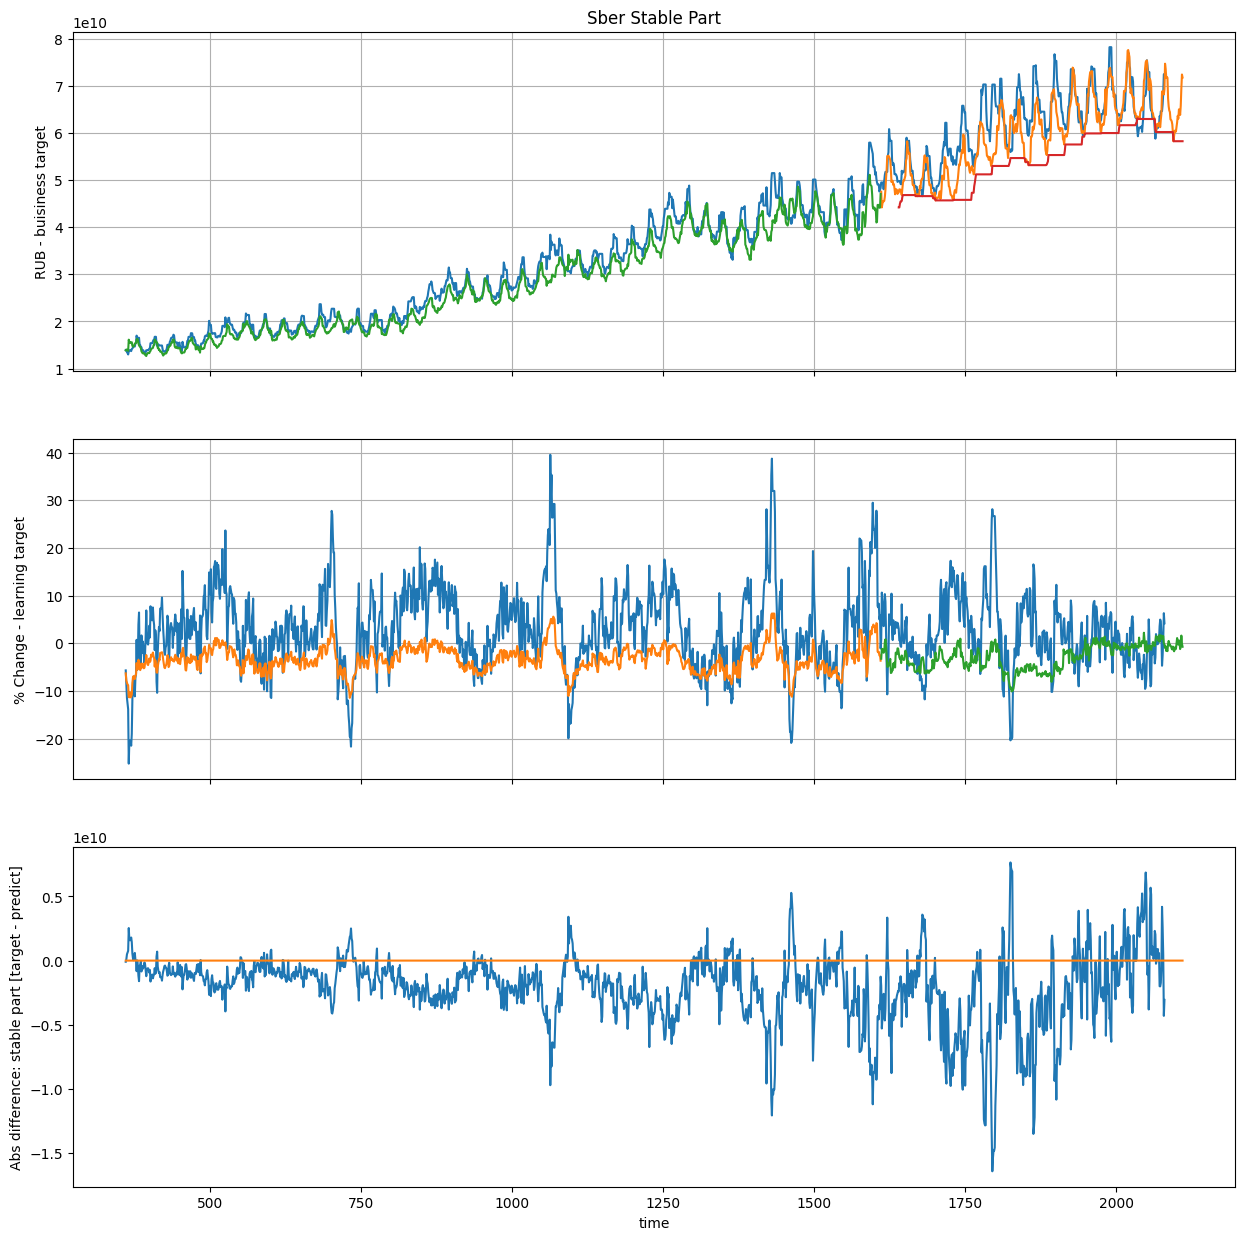

In [19]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(15, 15))
sta = 0

sns.lineplot(x=df.time, y=df.target_30, ax=ax[0])
sns.lineplot(x=df.time, y=target_pred["30"], ax=ax[0])
sns.lineplot(x=df.time[sta:], y=target_pred_train["30"][sta:], ax=ax[0])
sns.lineplot(x=df.time[sta:], y=limit(target_pred["30"], 30)[sta:], ax=ax[0])

sns.lineplot(x=df.time[sta:], y=y.target_change_30[sta:], ax=ax[1])
sns.lineplot(x=df.time[sta:], y=y_pred_t[0][sta:], ax=ax[1])
sns.lineplot(x=df.time, y=y_pred[0], ax=ax[1])

sns.lineplot(x=df.time[sta:], y=abs_err["30"], ax=ax[2])
sns.lineplot(x=df.time[sta:], y=0, ax=ax[2])

ax[0].set_title("Sber Stable Part")
ax[0].set_ylabel("RUB - buisiness target")
ax[1].set_ylabel("% Change - learning target")
ax[2].set_ylabel("Abs difference: stable part [target - predict]")
ax[0].grid()
ax[1].grid()

In [20]:
# USE THIS FUNCTION BELOW TO TEST WITH OTHER DATA

In [23]:
def sber_predict(period="1M", date="01-10-2019", histfile="ВС_DS_Сбер.csv"):
    scaler = StandardScaler()
    pers = {
        "1M": 1,
        "2M": 2,
        "3M": 3,
        "4M": 4,
        "5M": 5,
        "6M": 6,
        "7M": 7,
        "8M": 8,
        "9M": 9,
        "10M": 10,
        "11M": 11,
        "12M": 12,
    }
    days_hor = pers[period] * 30
    
    start = datetime.strftime(pd.Timestamp(date) - pd.DateOffset(months=pers[period]), "%m-%d-%Y")
    X, df = get_X(scaler, histfile, start)
    colnames = list(X.columns)

    model = joblib.load("finalized_model.sav")
    predictions = model.predict(X)

    X = pd.DataFrame(scaler.inverse_transform(X), columns=colnames)
    y_pred = pd.DataFrame(
        predictions,
    )
    target_pred = X.value + y_pred[pers[period] - 1] * X.value / 100
    
    fig, ax = plt.subplots(figsize=(15, 8))
    sns.lineplot(x=df.time, y=df.value)
    sns.lineplot(x=df.time + days_hor, y=target_pred)
    
    sns.lineplot(x=df.time, y=limit(target_pred, days_hor))
    sns.lineplot(x=range(df.time.values[-1], df.time.values[-1]+days_hor), y=limit(target_pred, days_hor).values[-1])

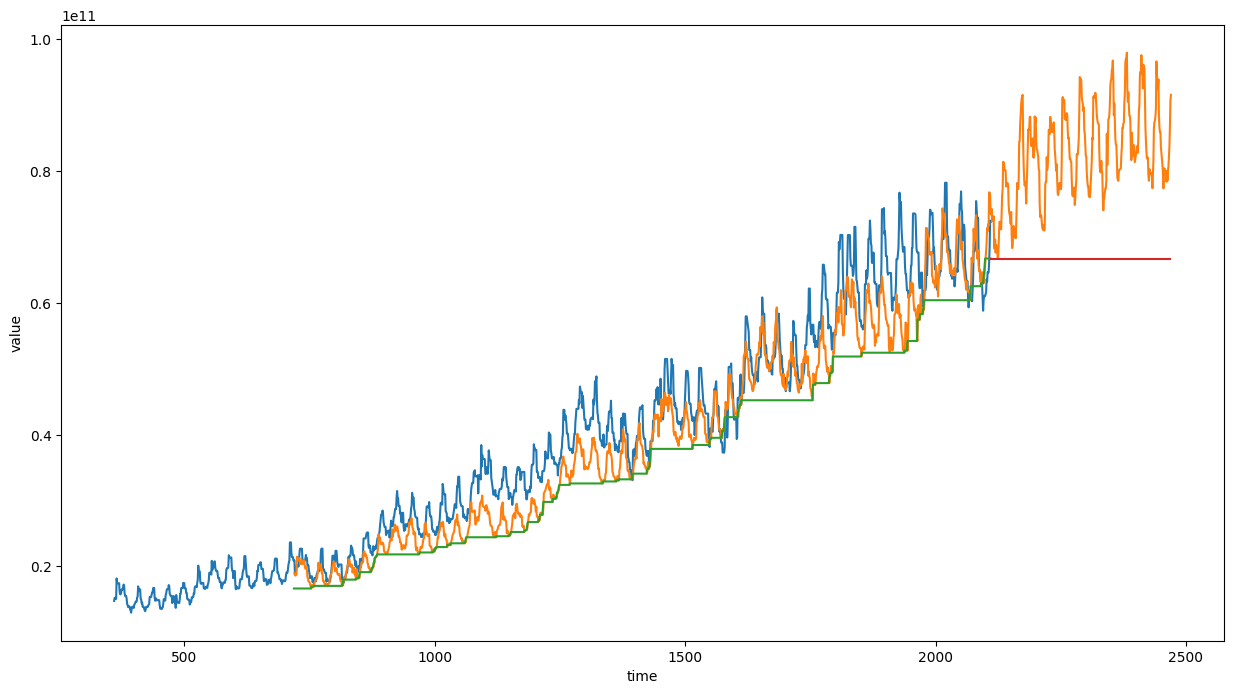

In [24]:
sber_predict(period="12M", date="01-01-2012", histfile="ВС_DS_Сбер.csv")